# Fly Me to the Moon
Name: Dan Ellsworth <br>
Date: 12 October 2020

## Data Scraping and Prep

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from fake_useragent import UserAgent
import datetime 
import re # regular expression
from Levenshtein import distance as levenshtein_distance
%matplotlib inline

### Step 1: Scrape Solar Flare Data
The spaceweatherlive data table is well organized - if we inspect the Html, we will quickly see the table we want to extract. We have to use UserAgent() (from fake_useragent import) to access the website. In my case, I used edge because it is the browser I use (but this could be changed to chrome or various other browsers). Once we have the text, we seek out each row and find all data cells within each row to create a Dataframe.

In [2]:
url = 'https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares'

# fake a human getting data from edge browser
ua = UserAgent()
header = {'User-Agent':str(ua.edge)}

# grab the html content and use BS4 to extract web info into text
htmlContent = requests.get(url, headers = header)
soup = BeautifulSoup(htmlContent.text, 'html.parser')
prettyhtml = soup.prettify()

#create empty list to store table data
data = []

#find the table on the website
table = soup.find("table", attrs={"class": "table table-striped table-responsive-md"})

# find the body of the table
table_body = table.find('tbody')

# find all rows in the table body
rows = table_body.find_all('tr')

# for each of these rows parse all data in each column
for row in rows:
    cols = row.find_all('td') # grab data from each data cell
    cols = [ele.text.strip() for ele in cols] # eliminate any default characters at beginning or end of string
    data.append([ele for ele in cols if ele]) # Get rid of empty values
    
# create Solar Flare DF from scraped spaceweatherlive.com data
SolarFlareDF = pd.DataFrame(data, columns = ['rank', 'x_class','date', 'region','start_time','max_time', 'end_time', 'movie'])
 
# Display the first 11 rows per the rubric
SolarFlareDF.head(11)

,rank,x_class,date,region,start_time,max_time,end_time,movie
0,1,X28+,2003/11/04,0486,19:29,19:53,20:06,MovieView archive
1,2,X20+,2001/04/02,9393,21:32,21:51,22:03,MovieView archive
2,3,X17.2+,2003/10/28,0486,09:51,11:10,11:24,MovieView archive
3,4,X17+,2005/09/07,0808,17:17,17:40,18:03,MovieView archive
4,5,X14.4,2001/04/15,9415,13:19,13:50,13:55,MovieView archive
5,6,X10,2003/10/29,0486,20:37,20:49,21:01,MovieView archive
6,7,X9.4,1997/11/06,8100,11:49,11:55,12:01,MovieView archive
7,8,X9.3,2017/09/06,2673,11:53,12:02,12:10,MovieView archive
8,9,X9,2006/12/05,0930,10:18,10:35,10:45,MovieView archive
9,10,X8.3,2003/11/02,0486,17:03,17:25,17:39,MovieView archive


### Step 2: Tidying the SolarFlareDF 
Since the spaceweatherlive data table was well organized, it makes tidying our Dataframe much easier. We combine the date and time columns to form three Datetime objects: start_datetime, max_datetime, and end_datetime. We ensure that all dtypes are how we intend and replace any null values with NaN. 

In [3]:
# drop the movie column
SolarFlareDF.drop('movie',axis = 1, inplace = True)

# list of 3 time columns we want to add date to
time_columns = ['start_time','max_time','end_time']

# for each time column, add date to each - ensuring each is converted to a datetime object
for col in time_columns:
    SolarFlareDF[col[:-4] + 'datetime'] =  pd.to_datetime(SolarFlareDF['date'] + ' ' + SolarFlareDF[col]) # add two columns and change type to datetime
    SolarFlareDF.drop([col], axis = 1, inplace = True) # drop the previous time column once new column is made

    
#drop the date column - we now have datetime columns instead
SolarFlareDF.drop(['date'] ,axis = 1)

# change dtype to numeric values for rank and region
SolarFlareDF['rank'] = pd.to_numeric(SolarFlareDF['rank'], errors='coerce') # errors will default to NaN
SolarFlareDF['region'] = pd.to_numeric(SolarFlareDF['region'], errors='coerce')


# replace any '-' with NaN value
SolarFlareDF.replace('-', np.nan, inplace = True)

# reindex columns
SolarFlareDF = SolarFlareDF.reindex(columns = ['rank', 'x_class', 'start_datetime', 'max_datetime', 'end_datetime', 'region'])

# print the dtypes of each variable
print(SolarFlareDF.info())
# display the first 11 observations
SolarFlareDF.head(11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   rank            50 non-null     int64         
 1   x_class         50 non-null     object        
 2   start_datetime  50 non-null     datetime64[ns]
 3   max_datetime    50 non-null     datetime64[ns]
 4   end_datetime    50 non-null     datetime64[ns]
 5   region          50 non-null     int64         
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 2.5+ KB
None


,rank,x_class,start_datetime,max_datetime,end_datetime,region
0,1,X28+,2003-11-04 19:29:00,2003-11-04 19:53:00,2003-11-04 20:06:00,486
1,2,X20+,2001-04-02 21:32:00,2001-04-02 21:51:00,2001-04-02 22:03:00,9393
2,3,X17.2+,2003-10-28 09:51:00,2003-10-28 11:10:00,2003-10-28 11:24:00,486
3,4,X17+,2005-09-07 17:17:00,2005-09-07 17:40:00,2005-09-07 18:03:00,808
4,5,X14.4,2001-04-15 13:19:00,2001-04-15 13:50:00,2001-04-15 13:55:00,9415
5,6,X10,2003-10-29 20:37:00,2003-10-29 20:49:00,2003-10-29 21:01:00,486
6,7,X9.4,1997-11-06 11:49:00,1997-11-06 11:55:00,1997-11-06 12:01:00,8100
7,8,X9.3,2017-09-06 11:53:00,2017-09-06 12:02:00,2017-09-06 12:10:00,2673
8,9,X9,2006-12-05 10:18:00,2006-12-05 10:35:00,2006-12-05 10:45:00,930
9,10,X8.3,2003-11-02 17:03:00,2003-11-02 17:25:00,2003-11-02 17:39:00,486


### Step 3: Scraping the NASA Data
Scraping the NASA data is a bit more difficult. The table is not as clearly defined when we inspect the Html. We will end up taking most of the text from the url page, and omit the parts that are irrelevant based on the gathered information. In this case, the first 11 lines of text are not a part of the table, so we can delete these and the last line is also miscellaneous so we delete this as well.

In [4]:
url = 'http://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html'

htmlContent = requests.get(url)
soup = BeautifulSoup(htmlContent.text, 'html.parser')
prettyhtml = soup.prettify()

# find the table on the website
table = soup.find("pre")

# make each newline an element in a list using split
listTable = (table.text.strip().split('\n'))

# omit text above data table (11 lines of text)
Data = listTable[11:]

Elements = []
FormatedData = []

# split each string by ' '
for row in Data:
    Elements.append(row.split(' '))

# omit empty list elements
for elem in Elements:
    FormatedData.append(list(filter(None, elem)))

# some data in table has additional notes at the end we don't care about - lets delete these notes
for data in FormatedData:
    if (len(data) != 15): # if len of data != 15
        del data[15:]   # delete anything beyond the inital 15 columns of data

del FormatedData[-1:]        # the last observation was junk i.e '================'

# create DF with specified columns
NasaDF = pd.DataFrame(FormatedData, columns = ['start_date', 'start_time','end_date', 'end_time','start_frequency','end_frequency', 'flare_location','flare_region', 'importance','cme_date', 'cme_time','cpa','cma_width', 'cma_speed', 'link_to_plot'])

NasaDF = NasaDF.drop('link_to_plot', axis = 1) # drop link_to_plot column

NasaDF.head(11)


,start_date,start_time,end_date,end_time,start_frequency,end_frequency,flare_location,flare_region,importance,cme_date,cme_time,cpa,cma_width,cma_speed
0,1997/04/01,14:00,04/01,14:15,8000,4000,S25E16,8026,M1.3,04/01,15:18,74,79,312
1,1997/04/07,14:30,04/07,17:30,11000,1000,S28E19,8027,C6.8,04/07,14:27,Halo,360,878
2,1997/05/12,05:15,05/14,16:00,12000,80,N21W08,8038,C1.3,05/12,05:30,Halo,360,464
3,1997/05/21,20:20,05/21,22:00,5000,500,N05W12,8040,M1.3,05/21,21:00,263,165,296
4,1997/09/23,21:53,09/23,22:16,6000,2000,S29E25,8088,C1.4,09/23,22:02,133,155,712
5,1997/11/03,05:15,11/03,12:00,14000,250,S20W13,8100,C8.6,11/03,05:28,240,109,227
6,1997/11/03,10:30,11/03,11:30,14000,5000,S16W21,8100,M4.2,11/03,11:11,233,122,352
7,1997/11/04,06:00,11/05,04:30,14000,100,S14W33,8100,X2.1,11/04,06:10,Halo,360,785
8,1997/11/06,12:20,11/07,08:30,14000,100,S18W63,8100,X9.4,11/06,12:10,Halo,360,1556
9,1997/11/27,13:30,11/27,14:00,14000,7000,N17E63,8113,X2.6,11/27,13:56,98,91,441


### Step 4: Tidying the NasaDF
 Here we follow the rubric to do the following tasks:
 -  Recode any missing entries as np.nan
 -  Make all versions of 'back' consistently BACK in 'flare_region' column
 -  Change 'DSF' to 'FILA' in 'flare_region' column
 -  Add a 'halo_flare' and 'width_lower_bound' column
 -  Combine date and time columns into one datetime object column
 -  Clean table and ensure the dtypes are correct for each variable
 

In [5]:

# Replace all indicated missing value symbols with NaN
NasaDF.replace(to_replace = ['---','----','-----','------','--/--','--:--', '????'], value = np.nan , inplace = True) # still empty --:-- check if okay
# make all versions of back consistently BACK
NasaDF['flare_location'].replace(to_replace = '[bB]ack*\D', value = 'BACK', inplace = True, regex = True) # replace all versions of back with upper case BACK
# replace DSF with FILA
NasaDF['flare_region'].replace(to_replace = 'DSF', value = 'FILA', inplace = True)
# add halo_flare column that has value True for Halo Flares and False otherwise
NasaDF['halo_flare'] = NasaDF['cpa'] == 'Halo'
# replace halo with NaN now that we have a seperate halo_flare column
NasaDF['cpa'].replace(to_replace = 'Halo', value = np.nan , inplace = True) # still empty --:-- check if okay
# replace end_time 24:00 with 23:59
NasaDF['end_time'].replace(to_replace = '24:00', value = '23:59', inplace = True)

# find all cma_width entries begining with '>' which indicates a lower bound
lower_bounds = re.findall('>.*', str(NasaDF['cma_width']))
# only keep numeric values after new lower bound is created
NasaDF['cma_width'] = NasaDF['cma_width'].str.extract('(\d+)', expand=False)  
# create an aditional column where value is True if cma_width is a lower bound and False otherwise
NasaDF['width_lower_bound'] = NasaDF['cma_width'].isin(lower_bounds)


# create year column - slicing year from start_date column - so we can append year to end_date and cme_date
NasaDF['year'] = NasaDF.start_date.str[:4]

# create 3 datetime objects: start, cme, and end datetime
NasaDF['end_datetime'] = pd.to_datetime(NasaDF['end_date'] + '/' + NasaDF['year'] + ' ' + NasaDF['end_time'])
NasaDF['cme_datetime'] = pd.to_datetime(NasaDF['cme_date'] + '/' + NasaDF['year'] + ' ' + NasaDF['cme_time'])
NasaDF['start_datetime'] = pd.to_datetime(NasaDF['start_date'] + ' ' + NasaDF['start_time'])

# drop all redundant columns 
NasaDF.drop(columns = ['year','start_date', 'start_time', 'cme_date', 'cme_time', 'end_date', 'end_time'], axis = 1, inplace = True)
# change the dtype of all numeric columns to float - in order to preserve NaN and allow floats if data were to include any
NasaDF[['start_frequency', 'end_frequency', 'cpa','cma_speed', 'cma_width']] = NasaDF[['start_frequency', 'end_frequency', 'cpa', 'cma_speed', 'cma_width']].apply(pd.to_numeric)

# NasaDF dtypes - note: floats are used instead of integers to allow more flexibility and NaN values
print(NasaDF.info())
# display NasaDF
NasaDF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   start_frequency    514 non-null    float64       
 1   end_frequency      514 non-null    float64       
 2   flare_location     510 non-null    object        
 3   flare_region       424 non-null    object        
 4   importance         404 non-null    object        
 5   cpa                210 non-null    float64       
 6   cma_width          496 non-null    float64       
 7   cma_speed          496 non-null    float64       
 8   halo_flare         518 non-null    bool          
 9   width_lower_bound  518 non-null    bool          
 10  end_datetime       518 non-null    datetime64[ns]
 11  cme_datetime       496 non-null    datetime64[ns]
 12  start_datetime     518 non-null    datetime64[ns]
dtypes: bool(2), datetime64[ns](3), float64(5), object(3)
memory usage

,start_frequency,end_frequency,flare_location,flare_region,importance,cpa,cma_width,cma_speed,halo_flare,width_lower_bound,end_datetime,cme_datetime,start_datetime
0,8000.0,4000.0,S25E16,8026,M1.3,74.0,79.0,312.0,False,False,1997-04-01 14:15:00,1997-04-01 15:18:00,1997-04-01 14:00:00
1,11000.0,1000.0,S28E19,8027,C6.8,NaN,360.0,878.0,True,False,1997-04-07 17:30:00,1997-04-07 14:27:00,1997-04-07 14:30:00
2,12000.0,80.0,N21W08,8038,C1.3,NaN,360.0,464.0,True,False,1997-05-14 16:00:00,1997-05-12 05:30:00,1997-05-12 05:15:00
3,5000.0,500.0,N05W12,8040,M1.3,263.0,165.0,296.0,False,False,1997-05-21 22:00:00,1997-05-21 21:00:00,1997-05-21 20:20:00
4,6000.0,2000.0,S29E25,8088,C1.4,133.0,155.0,712.0,False,False,1997-09-23 22:16:00,1997-09-23 22:02:00,1997-09-23 21:53:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,14000.0,210.0,S10W12,12673,M5.5,NaN,360.0,1418.0,True,False,2017-09-05 04:54:00,2017-09-04 20:12:00,2017-09-04 20:27:00
514,16000.0,70.0,S08W33,12673,X9.3,NaN,360.0,1571.0,True,False,2017-09-07 08:00:00,2017-09-06 12:24:00,2017-09-06 12:05:00
515,16000.0,150.0,S09W92,NaN,X8.3,NaN,360.0,3163.0,True,False,2017-09-11 06:50:00,2017-09-10 16:00:00,2017-09-10 16:02:00
516,16000.0,13000.0,N08E48,12680,C3.0,124.0,96.0,252.0,False,False,2017-09-12 07:43:00,2017-09-12 08:03:00,2017-09-12 07:38:00


# Part 2: Analysis

### Q1: Replication

To replicate the spaceweatherlive dataset, we need to extract all the observations that are classified as X flares (the most significant flares). We can do this by filtering the data using a regular expression. Further, we can sort these X flares based on their numerical classification (X28 is more significant than X17). This is an okay representation, but we still are not confident these observations match the ones in the spaceweatherlive dataset. We will see in Question 2, that we need to compare the two datasets based on multiple variables in order to be more certain two observations are referring to the same event.

In [6]:
# Change options to show all rows of DF - The remaining exersises are only dealing with the top 50 flares
pd.set_option('display.max_rows', None)

# Locate all flares with importance X__ - the most significant flares
Xflares = re.findall('[Xx].*', str(NasaDF['importance']))

# filter the Nasa dataset to only include observations of the most significant flares
XF_NasaDF = NasaDF[NasaDF['importance'].isin(Xflares)]

# find the coresponding numeric classification so we can rank the flares
Xnumber = re.findall('\d*\.\d*', str(XF_NasaDF['importance']))

# Using DataFrame.insert() to add a column 
XF_NasaDF.insert(loc = 5, column = "Xnumber", value = Xnumber)
# change dtype to numeric in order to sort numerical values
XF_NasaDF['Xnumber'] = pd.to_numeric(XF_NasaDF['Xnumber'], errors='coerce')

# display the NasaDF ranked by classification
XF_NasaDF.sort_values(by = 'Xnumber', ascending = False)


C:\Users\Danel\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,start_frequency,end_frequency,flare_location,flare_region,importance,Xnumber,cpa,cma_width,cma_speed,halo_flare,width_lower_bound,end_datetime,cme_datetime,start_datetime
240,10000.0,200.0,S19W83,10486,X28.,28.0,NaN,360.0,2657.0,True,False,2003-11-04 23:59:00,2003-11-04 19:54:00,2003-11-04 20:00:00
117,14000.0,250.0,N19W72,9393,X20.,20.0,261.0,244.0,2505.0,False,False,2001-04-03 02:30:00,2001-04-02 22:06:00,2001-04-02 22:05:00
233,14000.0,40.0,S16E08,10486,X17.,17.0,NaN,360.0,2459.0,True,False,2003-10-29 23:59:00,2003-10-28 11:30:00,2003-10-28 11:10:00
126,14000.0,40.0,S20W85,9415,X14.,14.0,245.0,167.0,1199.0,False,False,2001-04-16 13:00:00,2001-04-15 14:06:00,2001-04-15 14:05:00
234,11000.0,500.0,S15W02,10486,X10.,10.0,NaN,360.0,2029.0,True,False,2003-10-29 23:59:00,2003-10-29 20:54:00,2003-10-29 20:55:00
8,14000.0,100.0,S18W63,8100,X9.4,9.4,NaN,360.0,1556.0,True,False,1997-11-07 08:30:00,1997-11-06 12:10:00,1997-11-06 12:20:00
514,16000.0,70.0,S08W33,12673,X9.3,9.3,NaN,360.0,1571.0,True,False,2017-09-07 08:00:00,2017-09-06 12:24:00,2017-09-06 12:05:00
328,14000.0,250.0,S07E68,10930,X9.0,9.0,NaN,NaN,NaN,False,False,2006-12-05 20:00:00,NaT,2006-12-05 10:50:00
237,12000.0,250.0,S14W56,10486,X8.3,8.3,NaN,360.0,2598.0,True,False,2003-11-03 01:00:00,2003-11-02 17:30:00,2003-11-02 17:30:00
515,16000.0,150.0,S09W92,NaN,X8.3,8.3,NaN,360.0,3163.0,True,False,2017-09-11 06:50:00,2017-09-10 16:00:00,2017-09-10 16:02:00


We cannot replicate the spaceweatherlive data very well by comparing classifications because flare classification is not a unique identifier. To find corresponding observations we will need to compare multiple variables.

In [7]:
# reset index of new DF because we only care about X flares now
XF_NasaDF.reset_index(inplace = True)

### Q2: Integration - Using Levenshtein Distance

This function computes the Levenshtein distance between each observation in the spaceweatherlive data and the Nasa flare recordings starting with X (the most significant flares). The total distance is calculated by adding the following:

-  distance between each X_class (because xclass is occasionally formatted differently in each table)
-  distance between the start_datetime.date() (not including time - because times recorded are in different time zones)
-  the distance between end_datetime.date()
-  the difference between regions (where the flare was spotted)

If the Lev Distance is less than or equal to the threshold 4 (one difference for each variable considered), we will consider the two events the same.

In [8]:
def levenshtein_difference(XF_NasaDF, SolarFlareDF):
    
    # create a new DF for storing the matching 50 Nasa flare values
    NasaTop50 = pd.DataFrame(columns=['index','start_frequency','end_frequency','flare_location','flare_region','importance','cpa','cma_width','cma_speed','halo_flare','width_lower_bound','end_datetime','cme_datetime','start_datetime'])
    
    # compare observations from both tables
    for SolarRowIndex in range(len(SolarFlareDF)):
        for NasaRowIndex in range(len(XF_NasaDF)):
            # Calculate the difference by the following calculation: difference = diff(x_class) + diff(start_date) + diff(end_date) + diff(region)
            lev_distance = levenshtein_distance(XF_NasaDF['importance'][NasaRowIndex],SolarFlareDF['x_class'][SolarRowIndex]) + \
                           levenshtein_distance(str(XF_NasaDF['start_datetime'][NasaRowIndex].date()), str(SolarFlareDF['start_datetime'][SolarRowIndex].date())) + \
                           levenshtein_distance(str(XF_NasaDF['end_datetime'][NasaRowIndex].date()), str(SolarFlareDF['end_datetime'][SolarRowIndex].date())) + \
                           levenshtein_distance(str(XF_NasaDF['flare_region'][NasaRowIndex]), str(SolarFlareDF['region'][SolarRowIndex]))
            # if the distance is less than threshold (4), add the corresponding observation to the new NasaTop50 DF
            if lev_distance <= 4:
                NasaTop50 = NasaTop50.append(XF_NasaDF.iloc[NasaRowIndex], ignore_index = True)
                break
            # else if all values have been checked and there is no match - insert an empty row in DF
            elif(NasaRowIndex == len(XF_NasaDF)-1):
                NasaTop50 = NasaTop50.append(pd.Series(np.nan), ignore_index = True)
    
    ''' This part of the function is cleaning/tidying the NasaTop50 DF before returning it
    '''
    # drop any null values - these observations do not match the spaceweatherlive observations 
    NasaTop50.dropna(axis = 0, how = 'all', inplace = True)
    # make a new column called rank - since the DF was sorted by rank, the rank is equal to the index + 1
    NasaTop50['flare_rank'] = NasaTop50.index + 1
    # reset the index to the index that coresponds to the NasaDF
    NasaTop50.set_index(NasaTop50['index'], inplace = True, drop = True)
    
    return NasaTop50

In [9]:
''' This function adds a new column to the NASA dataset indicating its rank according
    to SpaceWeatherLive, if it appears in that dataset.
'''
def add_rank(NasaDF, NasaTop50):
    
    # left merge to match the indices of the NasaDF and NasaTop50 (flares) DF - this adds the rank column to the NasaDF
    NasaDF = NasaDF.merge(NasaTop50['flare_rank'], how = 'left', left_index = True, right_index=True)

    # reindex the columns so flare rank is the first variable
    NasaDF= NasaDF[['flare_rank', 'start_frequency','end_frequency','flare_location','flare_region','importance','cpa','cma_width','cma_speed','halo_flare','width_lower_bound','end_datetime','cme_datetime','start_datetime']]
    
    return NasaDF
    

#### Main():
> In the cell below, we are calling the two functions above and then displaying the output of the ranked flares that correspond to the spaceweatherlive dataset.

Note: I decided to break up the task into two functions because I felt these two tasks are independent of each other - calculating distance is different from merging info from both tables.

In [10]:
# determine the coresponding top 50 flares in the NasaDF using Levenshtein distance
NasaTop50 = levenshtein_difference(XF_NasaDF, SolarFlareDF)

# Merge data from both tables - add rank column to the NasaDF
NasaDF = add_rank(NasaDF, NasaTop50)

# display the ranked flares in order - (only flares that have a rank) - Note: not all 50 flares appear in this Nasa table
# flare_rank corespondes to the rank in the spaceweatherlive (SolarFlareDF) datatable
NasaRankedFlares = NasaDF[NasaDF.flare_rank.notnull()].sort_values(by = 'flare_rank')

''' Display the ranked flares in order - (only flares that have a rank) - Note: not all 50 flares appear 
    in this Nasa table. 
    flare_rank corespondes to the rank in the spaceweatherlive (SolarFlareDF) datatable
''' 
# display DF
NasaRankedFlares

,flare_rank,start_frequency,end_frequency,flare_location,flare_region,importance,cpa,cma_width,cma_speed,halo_flare,width_lower_bound,end_datetime,cme_datetime,start_datetime
240,1.0,10000.0,200.0,S19W83,10486,X28.,NaN,360.0,2657.0,True,False,2003-11-04 23:59:00,2003-11-04 19:54:00,2003-11-04 20:00:00
116,2.0,14000.0,5000.0,N20W70,9393,X1.1,270.0,80.0,992.0,False,False,2001-04-02 12:00:00,2001-04-02 11:26:00,2001-04-02 11:30:00
126,5.0,14000.0,40.0,S20W85,9415,X14.,245.0,167.0,1199.0,False,False,2001-04-16 13:00:00,2001-04-15 14:06:00,2001-04-15 14:05:00
234,6.0,11000.0,500.0,S15W02,10486,X10.,NaN,360.0,2029.0,True,False,2003-10-29 23:59:00,2003-10-29 20:54:00,2003-10-29 20:55:00
7,7.0,14000.0,100.0,S14W33,8100,X2.1,NaN,360.0,785.0,True,False,1997-11-05 04:30:00,1997-11-04 06:10:00,1997-11-04 06:00:00
514,8.0,16000.0,70.0,S08W33,12673,X9.3,NaN,360.0,1571.0,True,False,2017-09-07 08:00:00,2017-09-06 12:24:00,2017-09-06 12:05:00
328,9.0,14000.0,250.0,S07E68,10930,X9.0,NaN,NaN,NaN,False,False,2006-12-05 20:00:00,NaT,2006-12-05 10:50:00
237,10.0,12000.0,250.0,S14W56,10486,X8.3,NaN,360.0,2598.0,True,False,2003-11-03 01:00:00,2003-11-02 17:30:00,2003-11-02 17:30:00
288,12.0,14000.0,25.0,N14W61,10720,X7.1,NaN,360.0,882.0,True,False,2005-01-20 16:30:00,2005-01-20 06:54:00,2005-01-20 07:15:00
359,13.0,16000.0,4000.0,N17W69,11263,X6.9,NaN,360.0,1610.0,True,False,2011-08-09 08:35:00,2011-08-09 08:12:00,2011-08-09 08:20:00


> ### Integration Conclusion
> Considering the Levenshtein distance between multiple variables, we managed to match 34 of the 50 spaceweatherlive observations. If we change the threshold, we might get more matches, but we would be more susceptible to mistakes. To preserve integrity, it is safe to assume there are events not represented in the NASA dataset.

### Q3: Analysis Plot
I decided to look into whether Halo flares tend to be flares of higher significance (higher classification). To do this, I compare two pie charts that display the proportion of Halo CME's in the top 50 vs. the entire dataset.


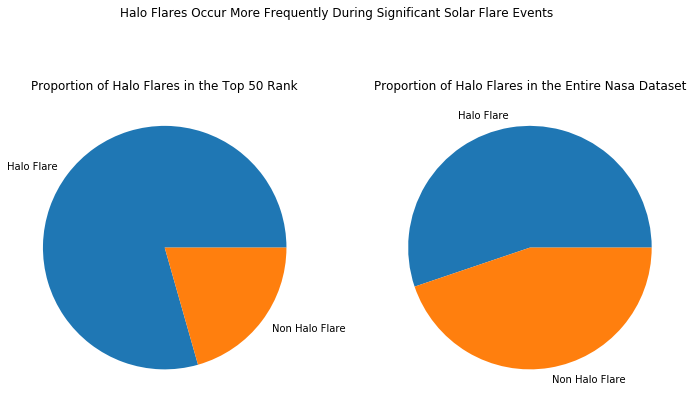

In [11]:
# Using Matplotlib for plotting
import matplotlib.pyplot as plt

# create two subplots - one for Top50 flares and another for the entire NasaDF
fig, (top50, entireDF) = plt.subplots(1, 2)
fig.suptitle('Halo Flares Occur More Frequently During Significant Solar Flare Events') # Create Plot title

# create a pie chart of the proportion of Halo flares in the top 50
top50.pie(NasaTop50.halo_flare.value_counts(), labels = ['Halo Flare', 'Non Halo Flare'])
top50.set_title('Proportion of Halo Flares in the Top 50 Rank') # set title

# create a pie chart of the proportion of Halo flares in the entire NasaDF
entireDF.pie(NasaDF.halo_flare.value_counts(), labels = ['Halo Flare', 'Non Halo Flare'])
entireDF.set_title('Proportion of Halo Flares in the Entire Nasa Dataset')

fig = plt.gcf() # get current figure
fig.set_size_inches(12,7) # Increase the size of the figure
plt.show(); #show plot


> ### Interpretation
It appears that Halo flares are more likely to occur during a significant solar event. Looking at the proportions that the two pie charts display, it is clear that more than 75% of the top 50 flares are Halo CME flares, while roughly 55% of all observations are Halo flares. Since we are summarizing a categorical variable, we cannot use measurements of center (mean, median, quantiles) or spread (Var, SD, MAD). Instead, we can use value counts and proportions. 

Note: The 'Proportion of Halo Flares in the Entire Nasa Dataset' chart also includes the flares ranked in the top 50. If we wanted to compare flares that are in the top 50 vs. flares not in the top 50, we could do the following:

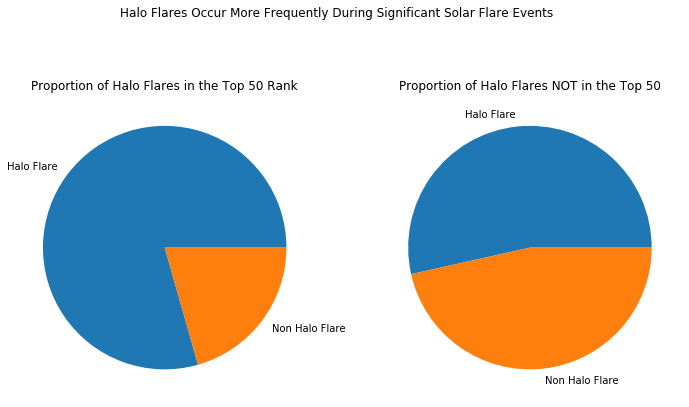

In [22]:
fig, (top50, notTop50) = plt.subplots(1, 2)
fig.suptitle('Halo Flares Occur More Frequently During Significant Solar Flare Events')

# create a pie chart of the proportion of Halo flares in the top 50
top50.pie(NasaTop50.halo_flare.value_counts(), labels = ['Halo Flare', 'Non Halo Flare'])
top50.set_title('Proportion of Halo Flares in the Top 50 Rank') # set title

# create a pie chart of the proportion of Halo flares in the entire NasaDF
notTop50.pie(NasaDF[NasaDF.flare_rank.isnull()].halo_flare.value_counts(), labels = ['Halo Flare', 'Non Halo Flare'])
notTop50.set_title('Proportion of Halo Flares NOT in the Top 50')

fig = plt.gcf() # get current figure
fig.set_size_inches(12,7) # Increase the size of the figure
plt.show(); #show plot

We can see that the difference is minor, but certainly noticeable if we look closely. By representing the data this way, there is no overlap in each representation (pie chart).